# Modelo precios del Oro 

In [139]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, callbacks

In [140]:
df_AU=pd.read_csv('XAU_USD_2016-2025_01-12_1h_bars.csv')
df_AU.head()

,UTC,Open,High,Low,Close,Volume
0,03.01.2016 23:00:00 UTC,1062.341,1066.321,1061.729,1063.059,1.61136
1,04.01.2016 00:00:00 UTC,1063.059,1064.740,1062.729,1064.459,2.77903
2,04.01.2016 07:00:00 UTC,1069.809,1073.052,1068.518,1071.321,3.45542
3,04.01.2016 05:00:00 UTC,1065.358,1068.949,1065.049,1068.659,3.96556
4,04.01.2016 06:00:00 UTC,1068.660,1070.119,1067.909,1069.801,2.40655


In [141]:
# Eliminación del texto " UTC" en los valores de la columna
df_AU['UTC'] = df_AU['UTC'].str.replace(' UTC', '', regex=False)

# Conversión de la cadena de texto en que está la fecha 'UTC' (tipo object,
# al formato Datetime 'DD.MM.YYYY HH:MM:SS'
df_AU['UTC'] = pd.to_datetime(df_AU['UTC'], format='%d.%m.%Y %H:%M:%S')

# Establecemos la columna "Date" como Índice, para poder luego trabajar con series de tiempo
df_AU = df_AU.set_index('UTC')



In [142]:
df_AU

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03 23:00:00,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04 00:00:00,1063.059,1064.740,1062.729,1064.459,2.77903
2016-01-04 07:00:00,1069.809,1073.052,1068.518,1071.321,3.45542
2016-01-04 05:00:00,1065.358,1068.949,1065.049,1068.659,3.96556
2016-01-04 06:00:00,1068.660,1070.119,1067.909,1069.801,2.40655
...,...,...,...,...,...
2025-11-21 20:00:00,4087.365,4088.495,4054.955,4067.098,3.64090
2025-11-23 23:00:00,4070.098,4077.285,4064.745,4074.905,1.19017
2025-11-24 02:00:00,4043.805,4051.385,4040.375,4043.345,1.35411


In [143]:
# asegurar índice datetime
df = df_AU.copy()
df.index = pd.to_datetime(df.index)

# contar observaciones por día (horas registradas)
counts = df['Close'].resample('D').count()
expected_per_day = 24
avail = pd.DataFrame({'count': counts})
avail['missing'] = expected_per_day - avail['count']

# mostrar resumen
print("Total días:", len(avail))
print("Días con 24 horas:", (avail['count'] == expected_per_day).sum())
print("Días incompletos (<24 horas):", (avail['count'] < expected_per_day).sum())
display(avail.head(10))



Total días: 3614
Días con 24 horas: 0
Días incompletos (<24 horas): 3614


,count,missing
UTC,,
2016-01-03,1,23
2016-01-04,23,1
2016-01-05,23,1
2016-01-06,23,1
2016-01-07,23,1
2016-01-08,22,2
2016-01-09,0,24
2016-01-10,1,23
2016-01-11,23,1


In [144]:
# Rango de fechas y días faltantes
start = df.index.min()
end = df.index.max()
print(f"Rango de datos: {start}  ->  {end}")

total_days = (end - start).days + 2  # incluir ambos extremos
print("Días totales en el rango:", total_days)


Rango de datos: 2016-01-03 23:00:00  ->  2025-11-24 02:00:00
Días totales en el rango: 3614


In [145]:
df_daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
})
df_daily

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.56875
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.43959
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.55685
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.99869
...,...,...,...,...,...
2025-11-20,4104.265,4109.805,4038.605,4078.675,63.94997
2025-11-21,4078.665,4100.839,4022.075,4064.279,63.53061
2025-11-22,NaN,NaN,NaN,NaN,0.00000


In [146]:
# Para usar el precio del día anterior en los días con datos faltantes
df_daily[['Open','High','Low','Close']] = df_daily[['Open','High','Low','Close']].ffill()
df_daily

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.56875
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.43959
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.55685
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.99869
...,...,...,...,...,...
2025-11-20,4104.265,4109.805,4038.605,4078.675,63.94997
2025-11-21,4078.665,4100.839,4022.075,4064.279,63.53061
2025-11-22,4078.665,4100.839,4022.075,4064.279,0.00000


In [147]:
df_daily.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [148]:
train = df_daily[
    (df_daily.index.year<=2023) & (df_daily.index.year>=2016)]
test = df_daily[(df_daily.index.year>2023)]

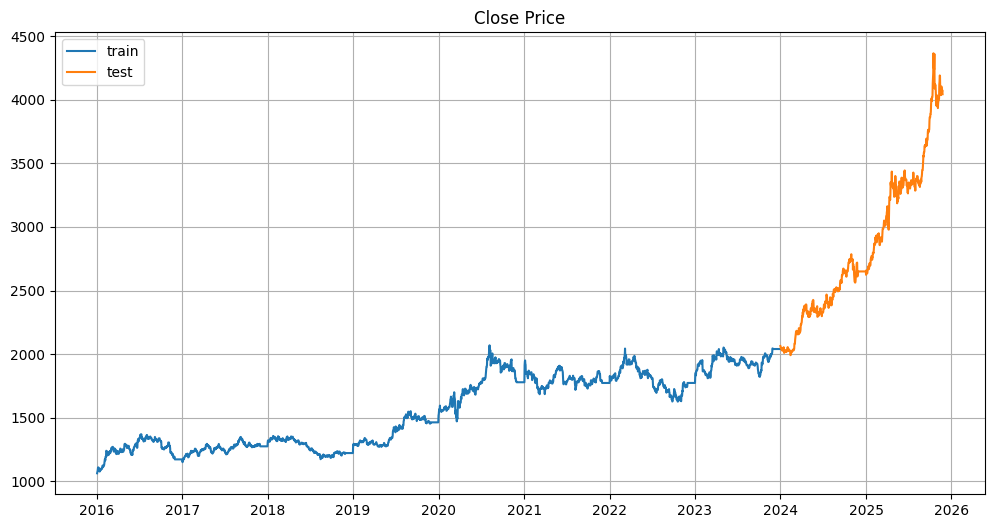

In [194]:
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label='train')
plt.plot(test['Close'], label='test')
plt.legend()
plt.title('Close Price')
plt.grid()
plt.show()

In [150]:
train

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.56875
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.43959
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.55685
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.99869
...,...,...,...,...,...
2023-12-27,2044.605,2047.118,2031.258,2040.005,0.00000
2023-12-28,2044.605,2047.118,2031.258,2040.005,0.00000
2023-12-29,2044.605,2047.118,2031.258,2040.005,0.00000


In [151]:
test

,Open,High,Low,Close,Volume
UTC,,,,,
2024-01-01,2062.598,2066.595,2062.405,2063.615,0.467980
2024-01-02,2063.625,2078.825,2055.818,2059.455,28.260549
2024-01-03,2059.475,2065.835,2030.515,2042.895,29.198980
2024-01-04,2042.865,2050.855,2036.155,2044.098,20.914870
2024-01-05,2044.128,2063.838,2024.255,2045.355,32.129880
...,...,...,...,...,...
2025-11-20,4104.265,4109.805,4038.605,4078.675,63.949970
2025-11-21,4078.665,4100.839,4022.075,4064.279,63.530610
2025-11-22,4078.665,4100.839,4022.075,4064.279,0.000000


In [152]:
# Escalado
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1,1))

# Crear ventanas
X_train, y_train = [], []

for i in range(80, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-80:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


In [ ]:
model = Sequential([

    LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1],1)),
    layers.Dropout(0.2), #El 0.2 hace referencia a la tasa de desactivación
    layers.LSTM(units=128, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(units=64),
    layers.Dropout(0.2),
    layers.Dense(units=1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])

/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [154]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 80, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 80, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 80, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,785 (1.95 MB)

 Trainable params: 510,785 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [155]:
early_stopping = callbacks.EarlyStopping(patience = 5, min_delta=0.001, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, callbacks=[early_stopping])

Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - loss: 0.0143 - mae: 0.0731 - mape: 16.8108 - mse: 0.0143
Epoch 2/30


/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 0.0032 - mae: 0.0412 - mape: 8.9097 - mse: 0.0032
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - loss: 0.0031 - mae: 0.0403 - mape: 8.6720 - mse: 0.0031
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - loss: 0.0031 - mae: 0.0400 - mape: 8.6641 - mse: 0.0031
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - loss: 0.0031 - mae: 0.0405 - mape: 8.8002 - mse: 0.0031
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 0.0027 - mae: 0.0377 - mape: 8.1867 - mse: 0.0027
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - loss: 0.0024 - mae: 0.0353 - mape: 7.6547 - mse: 0.0024
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - loss: 0.0025 - mae: 0.0360 - mape: 7.8287 - mse: 0.0025
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 0.0023 - mae: 0.0341 - mape: 7.2447 - mse: 0.0023
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - loss: 0.0021 - mae: 0.0336 - mape: 7.2714 - mse: 0.0021
Epoch 11/30

In [156]:
history_frame = pd.DataFrame(history.history)

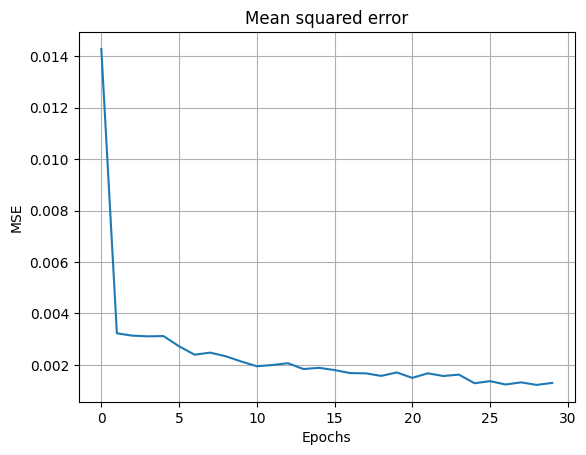

In [157]:
plt.plot(history_frame.loc[:,['mse']])
plt.title('Mean squared error')
plt.xlabel('Epochs')
plt.ylabel('MSE')   
plt.grid()
plt.show()

In [ ]:
dataset_total = df_daily['Close']
# Se crea un DF con los valores de entrada para hacer predicciones
inputs = dataset_total[len(dataset_total)-len(test['Close'].values) - 80:].values
# Se toma el precio de ayer y hoy para realizar prediccion de futuro
inputs = inputs.reshape(-1,1) # se redimensiona para tener en cuenta solo una tupla (vr_ayer, vr_hoy)
inputs = sc.transform(inputs) # Se aplica MinMaxScaler a las entradas para hacer predicciones

In [ ]:
# Crear lista dcon valores para realizar pruebas
x_test = []
for i in range (80,len(inputs)):
  x_test.append(inputs[i-80:i,0])
x_test = np.array(x_test) # Se crea un array con x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1)) 
predicted_price = model.predict(x_test) 
predicted_price = sc.inverse_transform(predicted_price) # Escala original

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [171]:
predictions = pd.DataFrame()
predictions["Actuals"] = test['Close'] # Valor actual
predictions['Predictions'] = predicted_price # valor prediccion

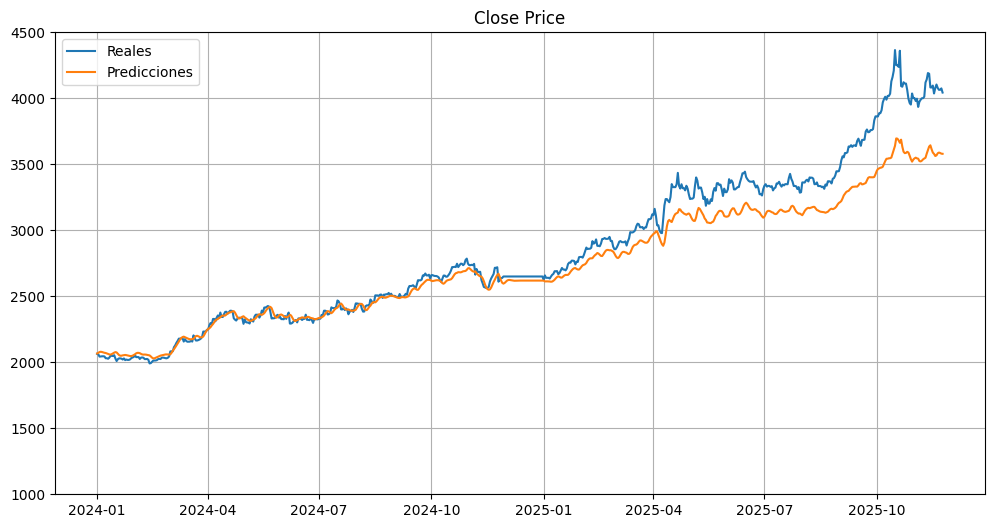

In [193]:
plt.figure(figsize=(12,6))
plt.title('Close Price')
plt.plot(predictions['Actuals'], label= 'Reales')
plt.plot(predictions['Predictions'], label= 'Predicciones')
plt.legend()
plt.ylim(1000,4500)
plt.grid()
plt.show()

In [186]:
# Métricas
rmse = np.sqrt(mean_squared_error(predictions['Actuals'], predictions['Predictions']))
mae = mean_absolute_error(predictions['Actuals'], predictions['Predictions'])
r2 = r2_score(predictions['Actuals'], predictions['Predictions'])
mape = np.mean(np.abs((predictions['Actuals'] - predictions['Predictions']) / predictions['Actuals'])) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 score: {r2:.4f}")

RMSE: 186.5585
MAE: 121.1917
MAPE: 3.59%
R2 score: 0.8962


In [175]:
train_multi_features = train[['Close', 'Volume']]
sc_multi = MinMaxScaler(feature_range=(0,1))
training_set_scaled_multi = sc_multi.fit_transform(train_multi_features)


In [ ]:
x_train_multi = []
y_train_multi = []
for i in range(80, len(training_set_scaled_multi)):
  x_train_multi.append(training_set_scaled_multi[i-80:i, :]) 
  y_train_multi.append(training_set_scaled_multi[i, 0])
x_train_multi, y_train_multi = np.array(x_train_multi), np.array(y_train_multi)

In [177]:
model_multi = Sequential([
    LSTM(units=256, return_sequences=True, input_shape=(x_train_multi.shape[1], x_train_multi.shape[2])),
    layers.Dropout(0.2),
    layers.LSTM(units=128, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(units=64),
    layers.Dropout(0.2),
    layers.Dense(units=1)
])
model_multi.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', 'mae', 'mape'])


/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping_multi = callbacks.EarlyStopping(
    patience = 5,
    min_delta=0.001,
    restore_best_weights=True
)
history_multi = model_multi.fit(x_train_multi, y_train_multi, epochs=30, batch_size=32, callbacks=[early_stopping_multi])


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0097 - mae: 0.0607 - mape: 13.7627 - mse: 0.0097
Epoch 2/30
 2/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0031 - mae: 0.0392 - mape: 7.0647 - mse: 0.0031

/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0032 - mae: 0.0417 - mape: 9.2194 - mse: 0.0032
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0031 - mae: 0.0409 - mape: 8.9478 - mse: 0.0031
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0026 - mae: 0.0373 - mape: 8.2179 - mse: 0.0026
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0024 - mae: 0.0361 - mape: 8.0711 - mse: 0.0024
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0026 - mae: 0.0372 - mape: 8.0841 - mse: 0.0026
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0024 - mae: 0.0354 - mape: 7.6104 - mse: 0.0024
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0023 - mae: 0.0343 - mape: 7.4094 - mse: 0.0023
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0022 - mae: 0.0339 - mape: 7.4038 - mse: 0.0022
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0022 - mae: 0.0337 - mape: 7.1776 - mse: 0.0022
Epoch 11/30
89/89 ━━━━━━━━━━━

In [ ]:
test_multi_features = test[['Close', 'Volume']]
inputs_multi = test_multi_features.values
inputs_multi = sc_multi.transform(inputs_multi) 

x_test_multi = []
for i in range(80, len(inputs_multi)): 
  x_test_multi.append(inputs_multi[i-80:i, :])
x_test_multi = np.array(x_test_multi)



/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
predicted_stock_price_multi_scaled = model_multi.predict(x_test_multi)

dummy_volume_column = np.zeros(predicted_stock_price_multi_scaled.shape)
predictions_combined = np.concatenate((predicted_stock_price_multi_scaled, dummy_volume_column), axis=1)

# Inverse transform the combined array
predicted_stock_price_multi = sc_multi.inverse_transform(predictions_combined)[:, 0] 

predictions_multi = pd.DataFrame()
predictions_multi["Actuals"] = test['Close'].iloc[len(inputs_multi) - len(x_test_multi):] 
predictions_multi['Predictions'] = predicted_stock_price_multi



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


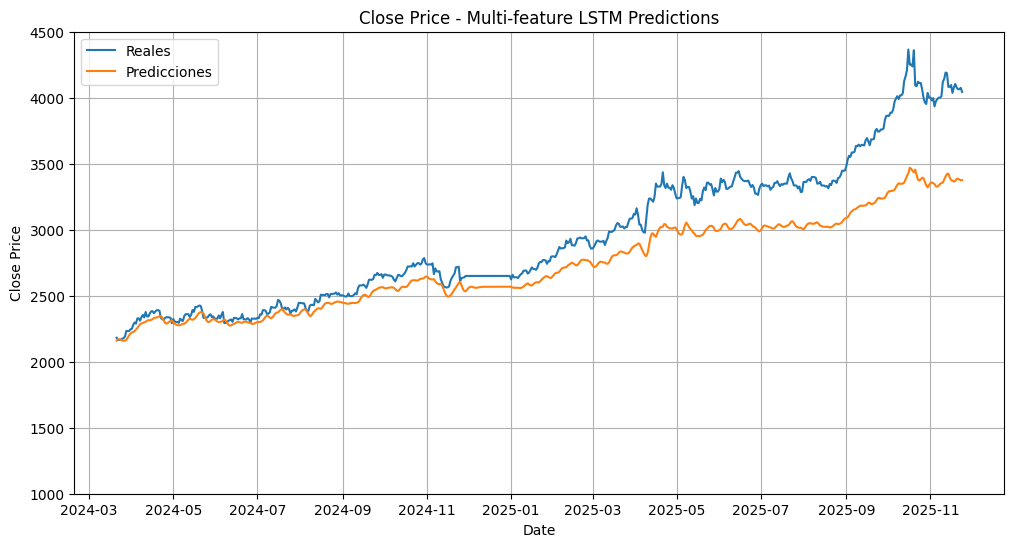

In [192]:
plt.figure(figsize=(12,6))
plt.title('Close Price - Multi-feature LSTM Predictions')
plt.plot(predictions_multi['Actuals'], label= 'Reales')
plt.plot(predictions_multi['Predictions'], label= 'Predicciones')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.ylim(1000,4500)
plt.legend()
plt.grid()
plt.show()

In [187]:
rmse = np.sqrt(mean_squared_error(predictions_multi['Actuals'], predictions_multi['Predictions']))
mae = mean_absolute_error(predictions_multi['Actuals'], predictions_multi['Predictions'])
r2 = r2_score(predictions_multi['Actuals'], predictions_multi['Predictions'])
mape = np.mean(np.abs((predictions_multi['Actuals'] - predictions_multi['Predictions']) / predictions_multi['Actuals'])) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 score: {r2:.4f}")

RMSE: 292.0736
MAE: 214.4133
MAPE: 6.41%
R2 score: 0.7041
